In [1]:
from dgpsi import dgp, kernel, combine, lgp, path, emulator
import numpy as np
import matplotlib.pyplot as plt

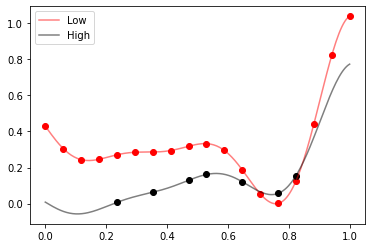

In [2]:
#Creating high and low fidelity functions
n=18
X=np.linspace(0,1.,n)[:,None]
f1= lambda x: ((6*x-2)**2*np.sin(12*x-4)+6)/21
f2= lambda x: 0.6*f1(x)+0.4*(x-0.5)-0.05
Y1=np.array([f1(x) for x in X]).reshape(-1,1)
Y2=np.array([f2(x) for x in X]).reshape(-1,1)
Y2[np.array([0,1,2,3,5,7,10,12,15,16,17]),:]=np.nan
Xt=np.linspace(0,1.,200)[:,None]
Yt1=np.array([f1(x) for x in Xt]).flatten()
Yt2=np.array([f2(x) for x in Xt]).flatten()
plt.plot(Xt,Yt1,color='r',alpha=0.5)
plt.plot(Xt,Yt2,color='black',alpha=0.5)
plt.scatter(X,Y1,color='r')
plt.scatter(X,Y2,color='black')
plt.legend(["Low","High"])

In [3]:
#Construct a four-layers DGP structure (with 2 effective two-layered DGPs) where the first two layers emulating the low fidelity model and the last two layers emulating the relationship between the output of low fidelity model and that of the high fidelity. We have the global input connected to the node in the third layer to inform the second DGP that the output also relates to the global input.
layer1=[kernel(length=np.array([1.]),name='sexp')]
layer2=[kernel(length=np.array([1.]),name='sexp')]
layer3=[kernel(length=np.array([1.]),name='sexp',connect=np.arange(1))]
layer4=[kernel(length=np.array([1.]),name='sexp',scale_est=1)]
all_layer=combine(layer1,layer2,layer3,layer4)

In [4]:
#Construct explicitly the output of each layer (first layer with nan, second layer with low fidelity observations, third layer with nan, and fourth layer with observations from the high fidelity model with nan at input positions of low fidelity model that are not evaluated for the high fidelity model)
Y=[np.full((len(Y1),1),np.nan),Y1,np.full((len(Y1),1),np.nan),Y2]
m=dgp(X,Y,all_layer)

In [5]:
#Train
m.train(N=1000)

Iteration 9: Layer 4:   1%|          | 9/1000 [00:00<01:55,  8.60it/s]/Users/deyu/Documents/GitHub/DGP/dgpsi/imputation.py:31: RuntimeWarning: covariance is not positive-semidefinite.
  target_kernel.output[target_kernel.missingness,0]=np.random.multivariate_normal(mean,covariance)
Iteration 1000: Layer 4: 100%|██████████| 1000/1000 [01:55<00:00,  8.66it/s]


In [6]:
#Construct emulator
final_layer_obj=m.estimate()
emu=emulator(final_layer_obj)

In [7]:
#Make predictions for the high fidelity model
z=np.linspace(0,1,200)[:,None].reshape(-1,1)
mu,var=emu.predict(z, N=50, method='mean_var')

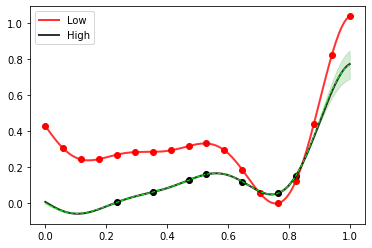

In [8]:
s=np.sqrt(var.T)
u=mu.T+2*s
l=mu.T-2*s
plt.plot(Xt,Yt1,color='r',alpha=0.8,lw=2)
plt.plot(Xt,Yt2,color='black',alpha=0.8,lw=2)
plt.scatter(X,Y1,color='r')
plt.scatter(X,Y2,color='black')
plt.legend(["Low","High"])
p=plt.plot(z,mu.T,'--',color='lime',alpha=1,lw=1)
plt.fill_between(Xt.flatten(), l.flatten(), u.flatten(), color='tab:green', alpha=0.2)